In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import norm, probplot
import re
import os

# Configuration
BASE_DIR = "/home/x-ctirapongpra/scratch/gw-collapsar/results/bayeswave_output_0"
DATA_DIR = os.path.join(BASE_DIR, "data")
TEMPLATES_DIR = os.path.join(BASE_DIR, "templates")
CHAINS_DIR = os.path.join(BASE_DIR, "chains")

DETECTORS = ['H1', 'L1']
SEGMENT_LENGTH = 4  # seconds
SAMPLING_RATE = 4096  # Hz
NUM_ITERATIONS = 11

# Plot styling
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("Setup complete!")
print(f"Base directory: {BASE_DIR}")
print(f"Detectors: {DETECTORS}")
print(f"Sampling rate: {SAMPLING_RATE} Hz")
print(f"Segment length: {SEGMENT_LENGTH} s")

Setup complete!
Base directory: /home/x-ctirapongpra/scratch/gw-collapsar/results/bayeswave_output_0
Detectors: ['H1', 'L1']
Sampling rate: 4096 Hz
Segment length: 4 s


In [2]:
def skip_headers(filename, num_header_lines=8):
    """Generator that skips BayesWave file headers."""
    with open(filename, 'r') as f:
        for _ in range(num_header_lines):
            next(f)
        for line in f:
            yield line

def load_time_domain_file(filepath):
    """Load time domain BayesWave output file.
    
    Returns:
        time_array, values_array
    """
    data = []
    for line in skip_headers(filepath, 8):
        parts = line.strip().split()
        if len(parts) == 2:
            data.append([float(parts[0]), float(parts[1])])
    data = np.array(data)
    return data[:, 0], data[:, 1]

def load_frequency_domain_file(filepath):
    """Load frequency domain BayesWave output file with complex values.
    
    Returns:
        freq_array, complex_array
    """
    frequencies = []
    complex_values = []
    
    for line in skip_headers(filepath, 8):
        parts = line.strip().split()
        if len(parts) == 2:
            freq = float(parts[0])
            # Parse complex number in format (real,imaginary)
            match = re.search(r'\(([^,]+),([^)]+)\)', parts[1])
            if match:
                real = float(match.group(1))
                imag = float(match.group(2))
                frequencies.append(freq)
                complex_values.append(real + 1j * imag)
    
    return np.array(frequencies), np.array(complex_values)

def reconstruct_signal_from_wavelets(wavelet_params_row, time_array):
    """Reconstruct gravitational wave signal from Morlet-Gabor wavelet parameters.
    
    Args:
        wavelet_params_row: Dictionary with keys 'time', 'frequency', 'qualityFactor', 
                           'amplitude', 'phase' - all arrays for a single iteration
        time_array: Time samples at which to reconstruct the signal
    
    Returns:
        strain: Reconstructed strain at each time sample
    """
    strain = np.zeros_like(time_array)
    
    # Each wavelet is a Morlet-Gabor wavelet
    for i in range(len(wavelet_params_row['time'])):
        t0 = wavelet_params_row['time'][i]
        f0 = wavelet_params_row['frequency'][i]
        Q = wavelet_params_row['qualityFactor'][i]
        A = wavelet_params_row['amplitude'][i]
        phi = wavelet_params_row['phase'][i]
        
        # Morlet-Gabor wavelet: A * exp(-2π²f0²(t-t0)²/Q²) * cos(2πf0(t-t0) + phi)
        tau = time_array - t0
        gaussian_envelope = np.exp(-2 * np.pi**2 * f0**2 * tau**2 / Q**2)
        oscillation = np.cos(2 * np.pi * f0 * tau + phi)
        
        strain += A * gaussian_envelope * oscillation
    
    return strain

def find_global_best_iteration(chains_dir):
    """Find iteration with maximum likelihood across ALL iterations and chains.
    
    Searches all_chain_likelihoods.txt file which contains likelihoods for all
    iterations (0-9999) and all chains (0-19).
    
    Args:
        chains_dir: Path to chains directory
    
    Returns:
        tuple: (best_cycle_index, best_chain_number, max_likelihood)
    """
    filepath = os.path.join(chains_dir, "all_chain_likelihoods.txt")
    
    # Load the file, skip header
    data = np.loadtxt(filepath, skiprows=1)
    
    # Column 0 is cycleIndex, columns 1-20 are likelihoods for chains 0-19
    likelihoods = data[:, 1:]  # All likelihood columns
    
    # Find global maximum
    max_idx_flat = np.argmax(likelihoods)
    best_cycle = max_idx_flat // likelihoods.shape[1]
    best_chain = max_idx_flat % likelihoods.shape[1]
    max_likelihood = likelihoods.flat[max_idx_flat]
    
    return int(best_cycle), int(best_chain), float(max_likelihood)

def find_best_saved_template(chains_dir, num_saved=11):
    """Find iteration with maximum likelihood among saved templates only.
    
    Searches only the first num_saved iterations where templates were saved.
    
    Args:
        chains_dir: Path to chains directory
        num_saved: Number of saved template iterations (default 11 for iterations 0-10)
    
    Returns:
        tuple: (best_cycle_index, best_chain_number, max_likelihood)
    """
    filepath = os.path.join(chains_dir, "all_chain_likelihoods.txt")
    
    # Load the file, skip header
    data = np.loadtxt(filepath, skiprows=1)
    
    # Only consider first num_saved iterations
    likelihoods = data[:num_saved, 1:]  # Rows 0 to num_saved-1, columns 1-20
    
    # Find maximum among saved templates
    max_idx_flat = np.argmax(likelihoods)
    best_cycle = max_idx_flat // likelihoods.shape[1]
    best_chain = max_idx_flat % likelihoods.shape[1]
    max_likelihood = likelihoods.flat[max_idx_flat]
    
    return int(best_cycle), int(best_chain), float(max_likelihood)

In [3]:
# Find the global best iteration (across all 10,000 iterations and 20 chains)
global_best_cycle, global_best_chain, global_max_likelihood = find_global_best_iteration(CHAINS_DIR)

# Find the best among saved templates (iterations 0-10)
best_saved_cycle, best_saved_chain, best_saved_likelihood = find_best_saved_template(CHAINS_DIR, NUM_ITERATIONS)


print(f"Global Maximum Likelihood: {global_max_likelihood:.2f}")
print(f"  - Iteration: {global_best_cycle} (Chain {global_best_chain})")
print(f"\nBest Saved Template Likelihood: {best_saved_likelihood:.2f}")
print(f"  - Iteration: {best_saved_cycle} (Chain {best_saved_chain})")


# Load wavelet parameters to get the structure for the global best iteration
wavelet_file = os.path.join(CHAINS_DIR, "gw_wavelets_elliptical_params_0.dat")

# Parse wavelets - each row has variable number of wavelets
wavelet_data_by_iteration = []

with open(wavelet_file, 'r') as f:
    header = f.readline()  # Skip header
    
    for line in f:
        values = line.strip().split()
        if len(values) == 0:
            continue
            
        values = [float(v) for v in values]
        num_wavelets = int(values[0])
        
        # Extract wavelets for this iteration
        wavelets = {
            'time': [],
            'frequency': [],
            'qualityFactor': [],
            'amplitude': [],
            'phase': []
        }
        
        for j in range(num_wavelets):
            base_idx = 1 + j * 5
            if base_idx + 4 < len(values):
                wavelets['time'].append(values[base_idx])
                wavelets['frequency'].append(values[base_idx + 1])
                wavelets['qualityFactor'].append(values[base_idx + 2])
                wavelets['amplitude'].append(values[base_idx + 3])
                wavelets['phase'].append(values[base_idx + 4])
        
        # Convert to arrays
        for key in wavelets:
            wavelets[key] = np.array(wavelets[key])
        
        wavelet_data_by_iteration.append(wavelets)

# Get the wavelets for the global best iteration
global_best_wavelets = wavelet_data_by_iteration[global_best_cycle]

# Dictionary to store all data
data = {}

# Load data for each detector
for det in DETECTORS:
    print(f"\nLoading {det} data...")
    
    # Time domain data
    data_file = os.path.join(DATA_DIR, f"colored_time_domain_data_{det}.dat")
    time_data, strain_data = load_time_domain_file(data_file)
    
    # Reconstruct signal from global best parameters
    print(f"  Reconstructing signal from global best iteration {global_best_cycle}...")
    strain_recon_global = reconstruct_signal_from_wavelets(global_best_wavelets, time_data)
    
    # Load ALL saved template iterations
    all_saved_templates = []
    for iter_idx in range(NUM_ITERATIONS):
        template_file = os.path.join(TEMPLATES_DIR, f"gw_all_colored_time_domain_template_{det}_{iter_idx}.dat")
        time_template, strain_template = load_time_domain_file(template_file)
        all_saved_templates.append(strain_template)
    
    # Compute residuals
    residual_global = strain_data - strain_recon_global
    
    # Frequency domain data
    freq_file = os.path.join(DATA_DIR, f"colored_frequency_domain_data_{det}.dat")
    freq_data, complex_data = load_frequency_domain_file(freq_file)
    
    # Noise PSD
    psd_file = os.path.join(DATA_DIR, f"noise_psd_{det}.dat")
    freq_psd, psd_values = load_time_domain_file(psd_file)
    
    # Store everything
    data[det] = {
        'time': time_data,
        'strain_data': strain_data,
        'strain_recon_global': strain_recon_global,
        'all_saved_templates': np.array(all_saved_templates),
        'residual_global': residual_global,
        'freq': freq_data,
        'complex_data': complex_data,
        'freq_psd': freq_psd,
        'psd': psd_values,
    }


Global Maximum Likelihood: 849669.69
  - Iteration: 10000 (Chain 0)

Best Saved Template Likelihood: 846432.16
  - Iteration: 10 (Chain 0)

Loading H1 data...
  Reconstructing signal from global best iteration 10000...

Loading L1 data...
  Reconstructing signal from global best iteration 10000...


### Time Domain Comparison Plot

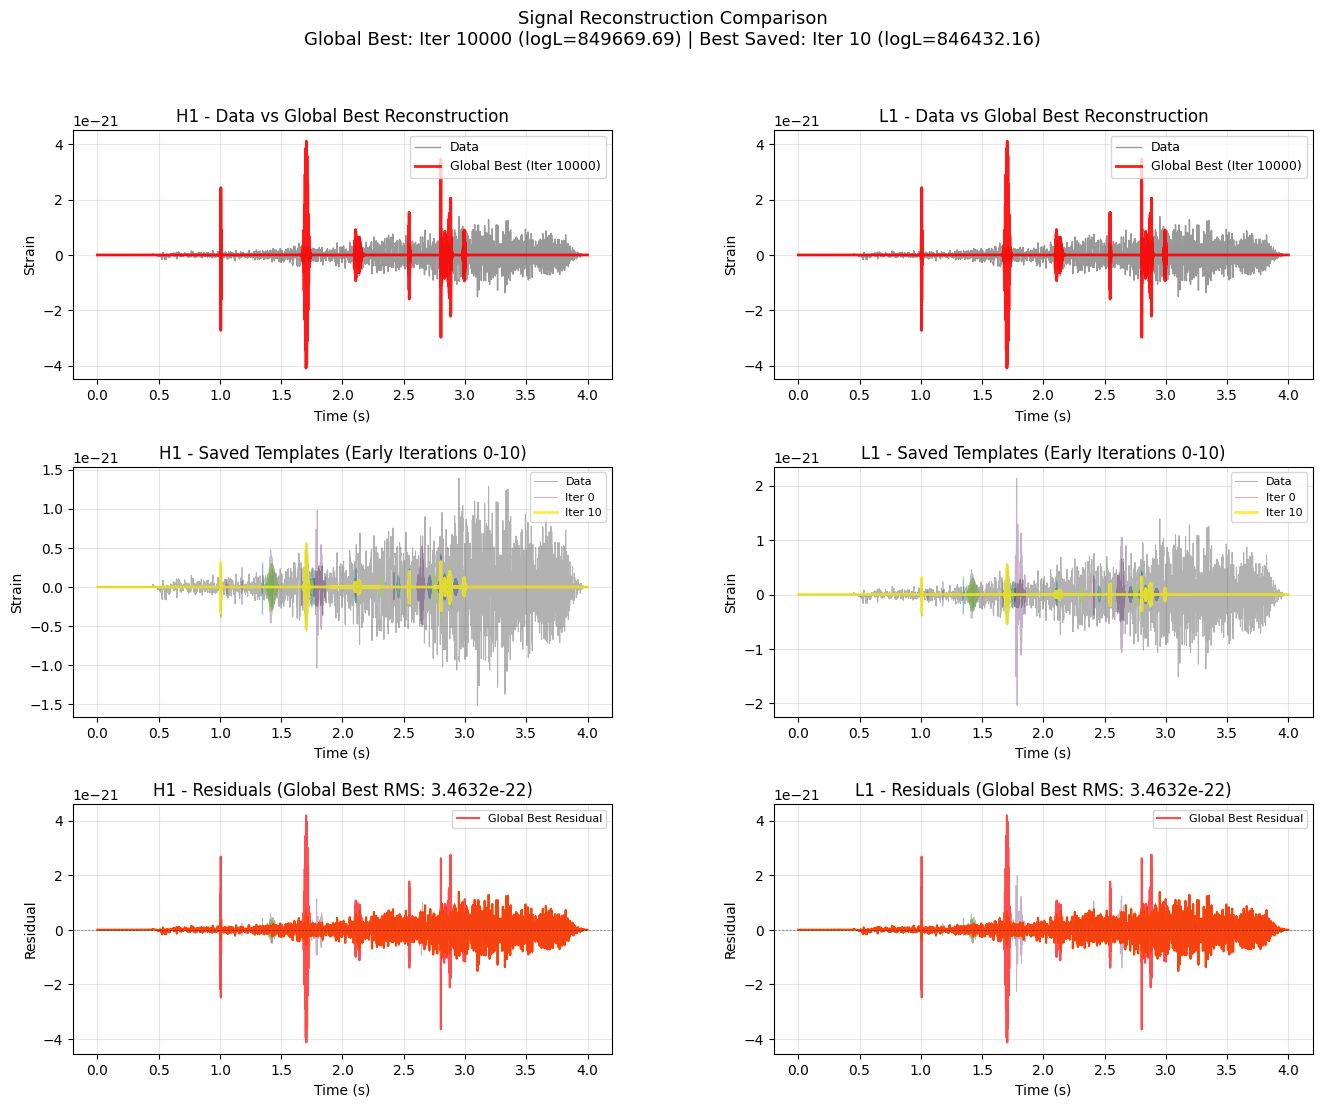

In [4]:
# Create figure with 2x2 grid - Saved templates comparison
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)

# Use colormap for saved template iterations
cmap = plt.cm.viridis
colors = [cmap(i / (NUM_ITERATIONS - 1)) for i in range(NUM_ITERATIONS)]

for i, det in enumerate(DETECTORS):
    # Row 1: Data + Global Best Reconstruction
    ax1 = fig.add_subplot(gs[0, i])
    ax1.plot(data[det]['time'], data[det]['strain_data'], 'k-', alpha=0.4, 
             label='Data', linewidth=1.0)
    ax1.plot(data[det]['time'], data[det]['strain_recon_global'], 'r-', alpha=0.9, 
             label=f'Global Best (Iter {global_best_cycle})', linewidth=2.0)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Strain')
    ax1.set_title(f'{det} - Data vs Global Best Reconstruction')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Row 2: All Saved Templates
    ax2 = fig.add_subplot(gs[1, i])
    ax2.plot(data[det]['time'], data[det]['strain_data'], 'k-', alpha=0.3, 
             label='Data', linewidth=0.8)
    
    for iter_idx in range(NUM_ITERATIONS):
        alpha = 0.3 if iter_idx != best_saved_cycle else 0.8
        linewidth = 0.8 if iter_idx != best_saved_cycle else 2.0
        label = None
        if iter_idx == 0:
            label = f'Iter {iter_idx}'
        elif iter_idx == NUM_ITERATIONS-1:
            label = f'Iter {iter_idx}'
        elif iter_idx == best_saved_cycle:
            label = f'Best Saved (Iter {iter_idx})'
        
        ax2.plot(data[det]['time'], data[det]['all_saved_templates'][iter_idx], 
                color=colors[iter_idx], alpha=alpha, linewidth=linewidth, label=label)
    
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Strain')
    ax2.set_title(f'{det} - Saved Templates (Early Iterations 0-{NUM_ITERATIONS-1})')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # Row 3: Residuals for all saved templates
    ax3 = fig.add_subplot(gs[2, i])
    
    for iter_idx in range(NUM_ITERATIONS):
        residual_iter = data[det]['strain_data'] - data[det]['all_saved_templates'][iter_idx]
        alpha = 0.3 if iter_idx != best_saved_cycle else 0.8
        linewidth = 0.6 if iter_idx != best_saved_cycle else 1.5
        ax3.plot(data[det]['time'], residual_iter, color=colors[iter_idx], 
                alpha=alpha, linewidth=linewidth)
    
    # Also plot global best residual in red
    ax3.plot(data[det]['time'], data[det]['residual_global'], 'r-', alpha=0.7, 
            linewidth=1.5, label=f'Global Best Residual')
    
    ax3.axhline(0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
    rms_global = np.sqrt(np.mean(data[det]['residual_global']**2))
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Residual')
    ax3.set_title(f'{det} - Residuals (Global Best RMS: {rms_global:.4e})')
    ax3.legend(loc='upper right', fontsize=8)
    ax3.grid(True, alpha=0.3)

# Create title
title_text = f'Signal Reconstruction Comparison\n'
title_text += f'Global Best: Iter {global_best_cycle} (logL={global_max_likelihood:.2f}) | '
title_text += f'Best Saved: Iter {best_saved_cycle} (logL={best_saved_likelihood:.2f})'
plt.suptitle(title_text, fontsize=13)
plt.savefig('signal_reconstruction_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Frequency Domain Comparison Plot

In [5]:
# Load extrinsic parameters
extrinsic_file = os.path.join(CHAINS_DIR, "gw_extrinsic_params_0.dat")
extrinsic_data = np.loadtxt(extrinsic_file, skiprows=1)

# Extract columns
extrinsic_params = {
    'rightAscension': extrinsic_data[:, 0],
    'sinDeclination': extrinsic_data[:, 1],
    'polarizationAngle': extrinsic_data[:, 2],
    'cosInclination': extrinsic_data[:, 3],
    'distance': extrinsic_data[:, 4],
    'phase': extrinsic_data[:, 5]
}

print(f"Loaded {len(extrinsic_data)} extrinsic parameter samples")
print(f"Parameters: {list(extrinsic_params.keys())}")

# Load wavelet parameters (complex structure - variable number of columns per row)
wavelet_file = os.path.join(CHAINS_DIR, "gw_wavelets_elliptical_params_0.dat")

# Parse wavelets - each row has variable number of wavelets
wavelet_params = {
    'numWavelets': [],
    'time': [],
    'frequency': [],
    'qualityFactor': [],
    'amplitude': [],
    'phase': []
}

# Read file line by line to handle variable columns
with open(wavelet_file, 'r') as f:
    # Skip header
    header = f.readline()
    
    # Read each line
    for line in f:
        values = line.strip().split()
        if len(values) == 0:
            continue
            
        values = [float(v) for v in values]
        num_wavelets = int(values[0])
        wavelet_params['numWavelets'].append(num_wavelets)
        
        # Each wavelet has 5 parameters: time, freq, Q, amp, phase
        for j in range(num_wavelets):
            base_idx = 1 + j * 5
            if base_idx + 4 < len(values):
                wavelet_params['time'].append(values[base_idx])
                wavelet_params['frequency'].append(values[base_idx + 1])
                wavelet_params['qualityFactor'].append(values[base_idx + 2])
                wavelet_params['amplitude'].append(values[base_idx + 3])
                wavelet_params['phase'].append(values[base_idx + 4])

# Convert lists to arrays
for key in ['time', 'frequency', 'qualityFactor', 'amplitude', 'phase']:
    wavelet_params[key] = np.array(wavelet_params[key])

wavelet_params['numWavelets'] = np.array(wavelet_params['numWavelets'])

print(f"\nLoaded {len(wavelet_params['numWavelets'])} wavelet parameter samples")
print(f"Total individual wavelets: {len(wavelet_params['time'])}")
print(f"Wavelet count range: {wavelet_params['numWavelets'].min():.0f} - {wavelet_params['numWavelets'].max():.0f}")
print(f"Median wavelets per sample: {np.median(wavelet_params['numWavelets']):.1f}")

Loaded 10001 extrinsic parameter samples
Parameters: ['rightAscension', 'sinDeclination', 'polarizationAngle', 'cosInclination', 'distance', 'phase']

Loaded 10001 wavelet parameter samples
Total individual wavelets: 99989
Wavelet count range: 6 - 10
Median wavelets per sample: 10.0


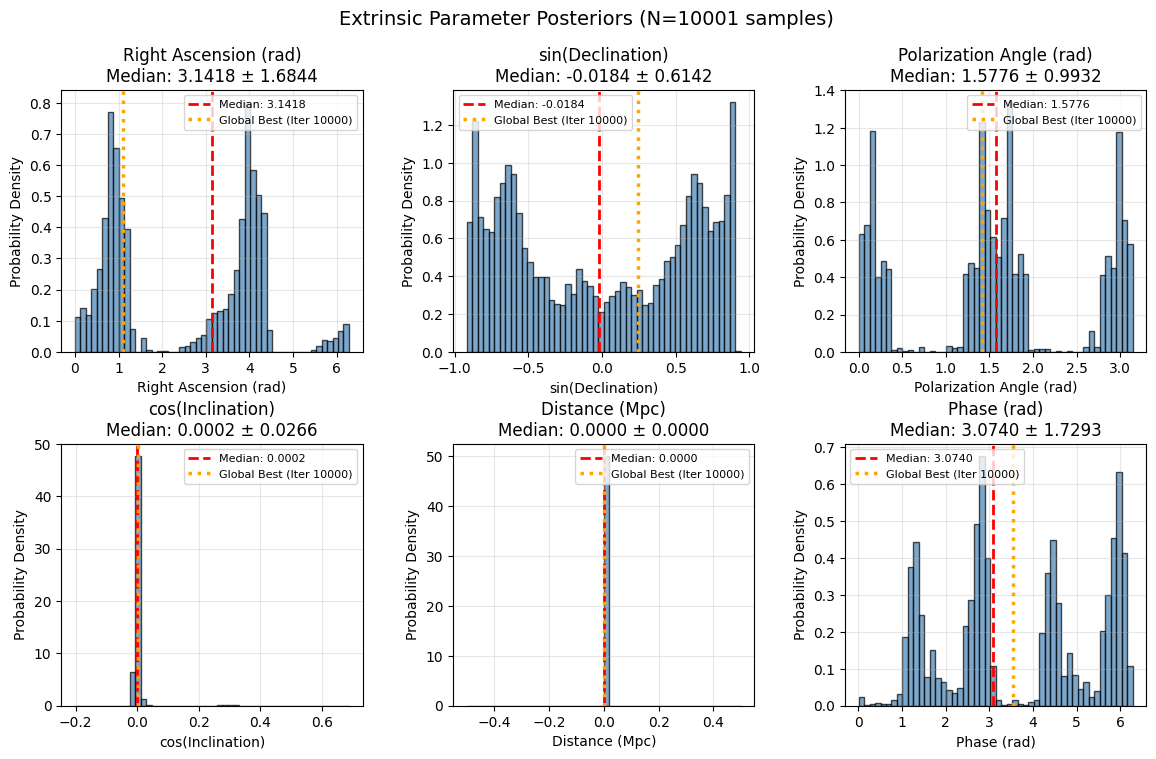

In [6]:
# Create figure with 2x3 grid
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.3)

param_names = [
    ('rightAscension', 'Right Ascension (rad)'),
    ('sinDeclination', 'sin(Declination)'),
    ('polarizationAngle', 'Polarization Angle (rad)'),
    ('cosInclination', 'cos(Inclination)'),
    ('distance', 'Distance (Mpc)'),
    ('phase', 'Phase (rad)')
]

for idx, (key, label) in enumerate(param_names):
    row = idx // 3
    col = idx % 3
    ax = fig.add_subplot(gs[row, col])
    
    values = extrinsic_params[key]
    median_val = np.median(values)
    std_val = np.std(values)
    
    # Get global best iteration's value
    global_best_value = extrinsic_params[key][global_best_cycle]
    
    ax.hist(values, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val:.4f}')
    ax.axvline(global_best_value, color='orange', linestyle=':', linewidth=2.5, 
               label=f'Global Best (Iter {global_best_cycle})')
    ax.set_xlabel(label)
    ax.set_ylabel('Probability Density')
    ax.set_title(f'{label}\nMedian: {median_val:.4f} ± {std_val:.4f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Extrinsic Parameter Posteriors (N={len(extrinsic_data)} samples)', fontsize=14)
plt.savefig('extrinsic_posteriors.png', dpi=150, bbox_inches='tight')
plt.show()

### Wavelet Parameter Posteriors

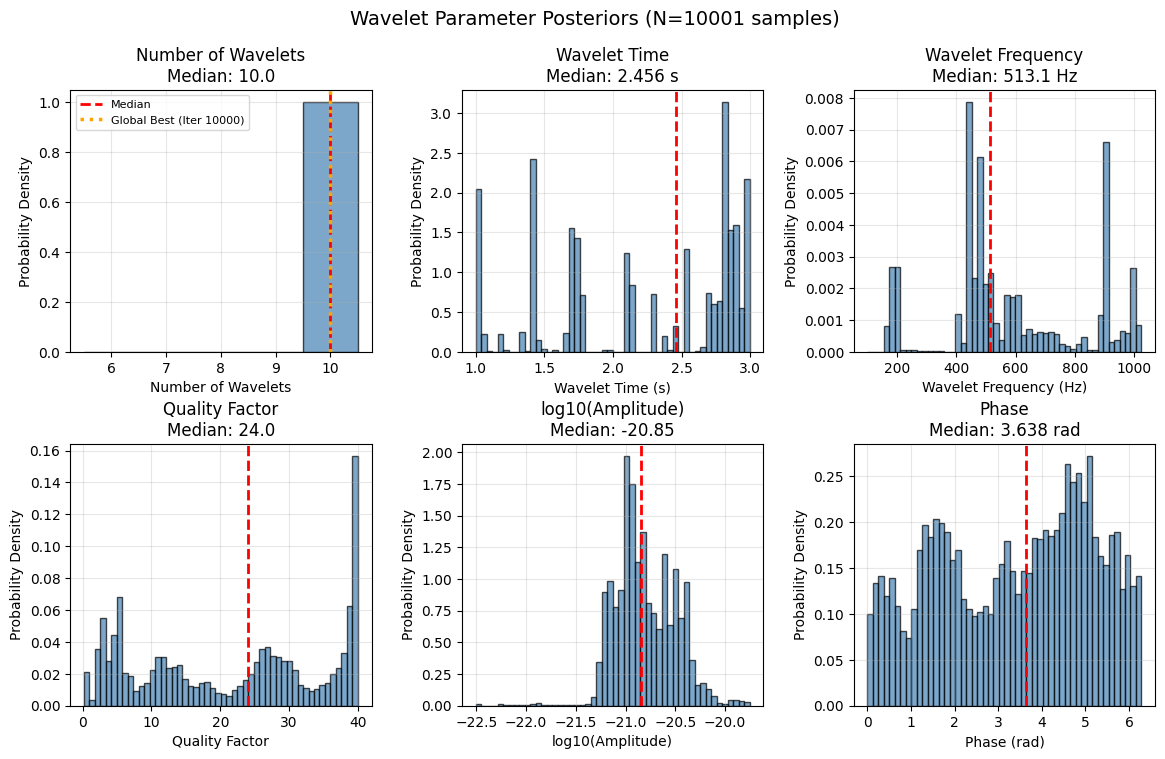

In [7]:
# Create figure with 2x3 grid
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.3)

# Number of wavelets (discrete)
ax = fig.add_subplot(gs[0, 0])
counts = wavelet_params['numWavelets']
bins = np.arange(counts.min() - 0.5, counts.max() + 1.5, 1)
ax.hist(counts, bins=bins, density=True, alpha=0.7, color='steelblue', edgecolor='black')
median_val = np.median(counts)
ax.axvline(median_val, color='red', linestyle='--', linewidth=2, label='Median')
# Global best iteration's wavelet count
global_best_num_wavelets = wavelet_params['numWavelets'][global_best_cycle]
ax.axvline(global_best_num_wavelets, color='orange', linestyle=':', linewidth=2.5,
           label=f'Global Best (Iter {global_best_cycle})')
ax.set_xlabel('Number of Wavelets')
ax.set_ylabel('Probability Density')
ax.set_title(f'Number of Wavelets\nMedian: {median_val:.1f}')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Wavelet time
ax = fig.add_subplot(gs[0, 1])
values = wavelet_params['time']
median_val = np.median(values)
ax.hist(values, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(median_val, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Wavelet Time (s)')
ax.set_ylabel('Probability Density')
ax.set_title(f'Wavelet Time\nMedian: {median_val:.3f} s')
ax.grid(True, alpha=0.3)

# Wavelet frequency
ax = fig.add_subplot(gs[0, 2])
values = wavelet_params['frequency']
median_val = np.median(values)
ax.hist(values, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(median_val, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Wavelet Frequency (Hz)')
ax.set_ylabel('Probability Density')
ax.set_title(f'Wavelet Frequency\nMedian: {median_val:.1f} Hz')
ax.grid(True, alpha=0.3)

# Quality factor
ax = fig.add_subplot(gs[1, 0])
values = wavelet_params['qualityFactor']
median_val = np.median(values)
ax.hist(values, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(median_val, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Quality Factor')
ax.set_ylabel('Probability Density')
ax.set_title(f'Quality Factor\nMedian: {median_val:.1f}')
ax.grid(True, alpha=0.3)

# Amplitude (log scale)
ax = fig.add_subplot(gs[1, 1])
values = wavelet_params['amplitude']
# Filter out very small values for log plot
values_filtered = values[values > 0]
log_values = np.log10(values_filtered)
median_val = np.median(log_values)
ax.hist(log_values, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(median_val, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('log10(Amplitude)')
ax.set_ylabel('Probability Density')
ax.set_title(f'log10(Amplitude)\nMedian: {median_val:.2f}')
ax.grid(True, alpha=0.3)

# Phase
ax = fig.add_subplot(gs[1, 2])
values = wavelet_params['phase']
median_val = np.median(values)
ax.hist(values, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(median_val, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Phase (rad)')
ax.set_ylabel('Probability Density')
ax.set_title(f'Phase\nMedian: {median_val:.3f} rad')
ax.grid(True, alpha=0.3)

plt.suptitle(f'Wavelet Parameter Posteriors (N={len(wavelet_params["numWavelets"])} samples)', fontsize=14)
plt.savefig('wavelet_posteriors.png', dpi=150, bbox_inches='tight')
plt.show()